# Import

In [1]:
import sys
import os
from datetime import datetime

root_dir = '../../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, evaluators, trainers, datasets, distributions

# Output settings

In [2]:
out_to_file = True
out_dir = '../../out/comparison/ml_100k/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Dataset

In [3]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
n_feedback = dataset.n_pos_pairs
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

In [4]:
print(f'n_user = {n_user}')
print(f'n_item = {n_item}')
print(f'n_feedback = {n_feedback}')

n_user = 940
n_item = 1447
n_feedback = 55369


# Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

In [6]:
print(device)

cuda:0


# Evaluator

In [7]:
# The size of recommendation set (K)
ks = [10]

# Compute average of 10 predictions score
n_prediction = 10

score_function_dict = {
    "Recall"       : evaluators.recall,
    "Unpopularity" : evaluators.unpopularity,
    "Serendipity"  : evaluators.serendipity,
    "Long-tail rate": evaluators.longtail_rate,
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)

# Sampler

In [8]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [9]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# Result (before training)

In [10]:
knn = searches.NearestNeighborhood(model)

In [11]:
trainer.valid(knn, userwise)
re_pre = trainer.valid_scores.copy()

In [12]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("pre_%Y_%m_%d_%H%M.csv")
    re_pre.to_csv(out_dir + file_name, index=False)

display(re_pre)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.125038,308.021699,3.101109,0.767766


# Training

In [13]:
trainer.fit(n_batch, n_epoch)

# Result

## CML (Base)

In [14]:
knn = searches.NearestNeighborhood(model)

In [15]:
re_base = pd.DataFrame()
for _ in range(n_prediction):
    trainer.valid(knn, userwise)
    _df = trainer.valid_scores.copy()
    re_base = pd.concat([re_base, _df])
re_base = re_base.mean()

In [16]:
re_base = re_base.to_frame().T

In [17]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("base_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(out_dir + file_name, index=False)

display(re_base)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.569724,31.198484,6.987715,0.182979


# MPCMP

In [18]:
# Hyperparameters
n_sample = 110
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [19]:
rows = []
for bias in bias_li:
    print(f'Prosessing... [bias = {bias}]')
    
    row = pd.DataFrame()
    for _ in range(n_prediction):
        mp = searches.MutualProximity(model, gamma, n_sample, bias)
        trainer.valid(mp, userwise)
        _df = trainer.valid_scores.copy()
        row = pd.concat([row, _df])
    row_mean = row.mean().to_frame().T
    row_mean.insert(0, 'Bias', bias)
    rows.append(row_mean)

re_mpcml = pd.concat(rows)

Prosessing... [bias = 0.0]
Prosessing... [bias = 0.1]
Prosessing... [bias = 0.2]
Prosessing... [bias = 0.3]
Prosessing... [bias = 0.4]
Prosessing... [bias = 0.5]
Prosessing... [bias = 0.6]
Prosessing... [bias = 0.7]
Prosessing... [bias = 0.8]
Prosessing... [bias = 0.9]
Prosessing... [bias = 1.0]


In [20]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_%Y_%m_%d_%H%M.csv")
    re_mpcml.to_csv(out_dir + file_name, index=False)

display(re_mpcml)

,Bias,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.0,0.365361,187.559398,9.912549,0.618670
0,0.1,0.414678,124.440915,9.922830,0.544947
0,0.2,0.442289,99.044533,9.609113,0.495085
0,0.3,0.464325,83.543967,9.385697,0.453191
0,0.4,0.484309,71.625712,9.110213,0.416564
0,0.5,0.502778,61.658111,8.887280,0.381372
0,0.6,0.517840,54.278048,8.706490,0.348777
0,0.7,0.533074,47.672210,8.426552,0.313479
0,0.8,0.545821,42.379454,8.153055,0.277979
0,0.9,0.558701,36.968805,7.737842,0.235840


## CML vs MPCML

In [21]:
# df -> list

k = 10
n_bias = len(bias_li)

# Before training
recall_pre         = re_pre[f'Recall@{k}'].tolist() * n_bias
unpopularity_pre   = re_pre[f'Unpopularity@{k}'].tolist() * n_bias
serendipity_pre     = re_pre[f'Serendipity@{k}'].tolist() * n_bias
longtale_pre       = re_pre[f'Long-tail rate@{k}'].tolist() * n_bias

# CML(Base)
recall_base        = re_base[f'Recall@{k}'].tolist() * n_bias
unpopularity_base  = re_base[f'Unpopularity@{k}'].tolist() * n_bias
serendipity_base    = re_base[f'Serendipity@{k}'].tolist() * n_bias
longtale_base      = re_base[f'Long-tail rate@{k}'].tolist() * n_bias

# MPCML
recall_mpcml       = re_mpcml[f'Recall@{k}'].tolist()
unpopularity_mpcml = re_mpcml[f'Unpopularity@{k}'].tolist()
serendipity_mpcml   = re_mpcml[f'Serendipity@{k}'].tolist()
longtale_mpcml     = re_mpcml[f'Long-tail rate@{k}'].tolist()

### Recall vs Unpopularity

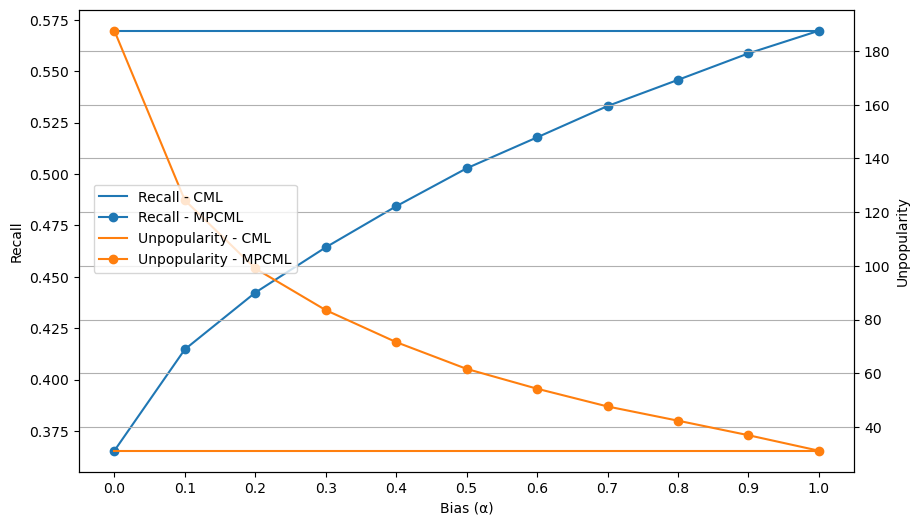

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Recall
line_recall_base  = ax1.plot(bias_li, recall_base,  label='Recall - CML', color='tab:blue')
line_recall_mpcml = ax1.plot(bias_li, recall_mpcml, label='Recall - MPCML', marker='o', color='tab:blue')

# Unpopularity
ax2 = ax1.twinx()
line_unpop_base  = ax2.plot(bias_li, unpopularity_base,  label='Unpopularity - CML', color='tab:orange')
line_unpop_mpcml = ax2.plot(bias_li, unpopularity_mpcml, label='Unpopularity - MPCML', marker='o', color='tab:orange')

ax1.set_xticks(bias_li)
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.set_xlabel('Bias (α)')
ax1.set_ylabel('Recall')
ax2.set_ylabel('Unpopularity')

lines = [line_recall_base[0], line_recall_mpcml[0], line_unpop_base[0], line_unpop_mpcml[0]]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, bbox_to_anchor=(0.35, 0.6))

plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("tradeoff_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Serendipity

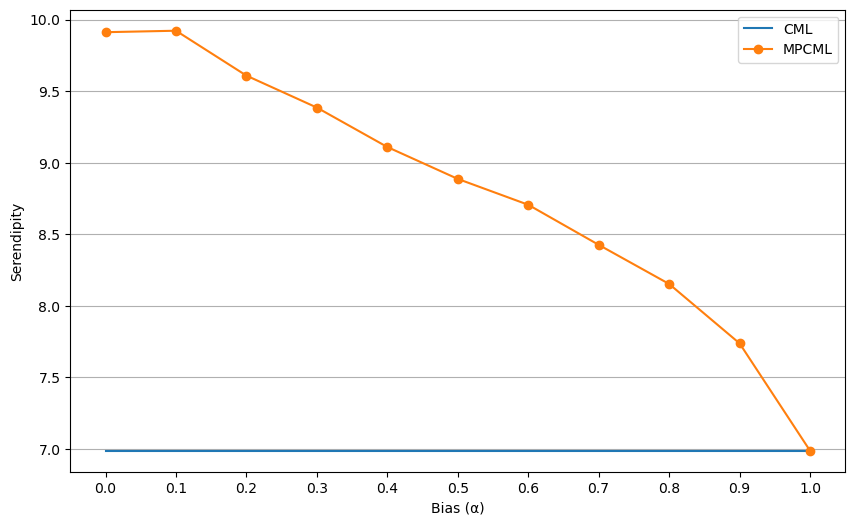

In [23]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, serendipity_pre, label='Before training)
plt.plot(bias_li, serendipity_base, label='CML')
plt.plot(bias_li, serendipity_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Serendipity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("serendipity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Long-tail rate

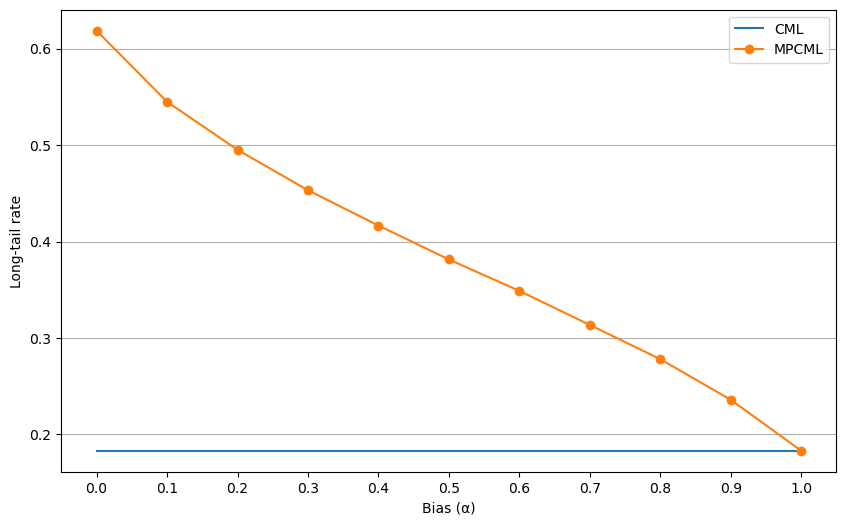

In [24]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, longtale_pre, label='Before training')
plt.plot(bias_li, longtale_base, label='CML')
plt.plot(bias_li, longtale_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Long-tail rate')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("longtail_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()